In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style(style="darkgrid")

In [56]:
df = pd.read_csv('data/dataset_practica_final_preprocessed.csv')

In [57]:
df.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,is_canceled
0,3.045939,-1.764027,0.011822,-1.676896,-0.974172,-1.278453,0.198253,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
1,7.636196,-1.764027,0.011822,-1.676896,-0.974172,-1.278453,0.198253,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
2,-0.847064,-1.764027,0.011822,-1.676896,-0.974172,-0.791496,-1.397925,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
3,-0.777338,-1.764027,0.011822,-1.676896,-0.974172,-0.791496,-1.397925,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
4,-0.765717,-1.764027,0.011822,-1.676896,-0.974172,-0.304540,0.198253,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0


In [58]:
df.shape

(87396, 247)

In [59]:
#* Separamos las variables predictoras y la variable objetivo
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [60]:
#* Dividimos en datos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [61]:
X_train.shape, X_test.shape

((69916, 246), (17480, 246))

- Entrenamiento del modelo RandomForest usando RandomizedSearchCV para optimizar hiperparámetros.

In [62]:
# Modelo base
modelo_rf = RandomForestClassifier(random_state=42)

In [63]:
# Rango de hiperparámetros para búsqueda aleatoria
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

# Búsqueda de hiperparámetros con validación cruzada
random_search = RandomizedSearchCV(
    estimator=modelo_rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [64]:
# Entrenamos el modelo con los mejores hiperparámetros encontrados
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, ...], 'min_samples_split': [2, 5], 'n_estimators': [50, 100]}"
,n_iter,5
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [65]:
# Modelo óptimo
best_model_rf = random_search.best_estimator_
model_rf = best_model_rf
model_rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [66]:
#* Predicciones
y_pred = model_rf.predict(X_test)
y_proba = model_rf.predict_proba(X_test)[:, 1]

y_pred[:10], y_proba[:10]

(array([0, 1, 1, 0, 0, 0, 1, 1, 1, 0]),
 array([0.09958516, 0.65795238, 0.65877381, 0.29661075, 0.33789286,
        0.162     , 0.78990476, 0.66219372, 0.79570563, 0.        ]))

In [67]:
# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.85
Precisión: 0.78
Recall:    0.62
F1-Score:  0.69
AUC:       0.91



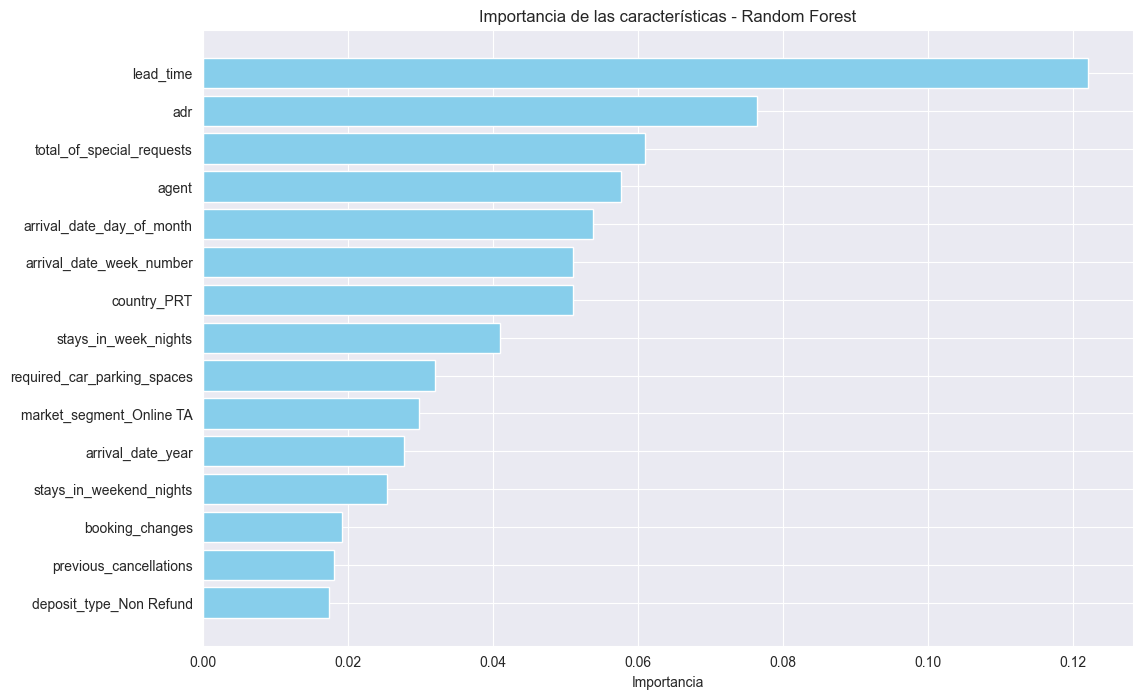

In [68]:
# Gráfico de las 15 características más importantes
importances = model_rf.feature_importances_
indices = importances.argsort()[::-1][:15]
features = X_train.columns[indices]
plt.figure(figsize=(12, 8))
plt.barh(features, importances[indices], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las características - Random Forest')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la más importante arriba
plt.show()

<Figure size 800x600 with 0 Axes>

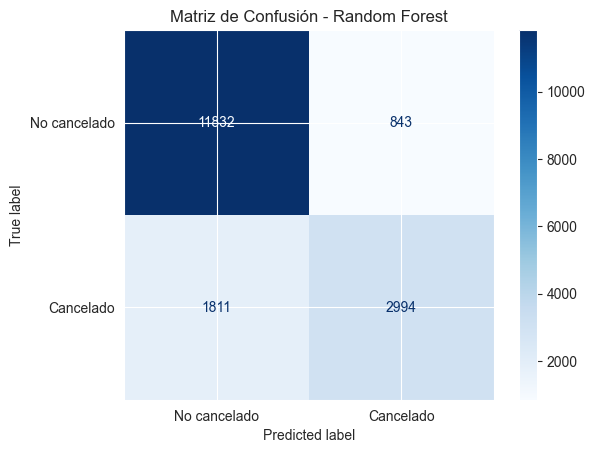

In [69]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No cancelado', 'Cancelado'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

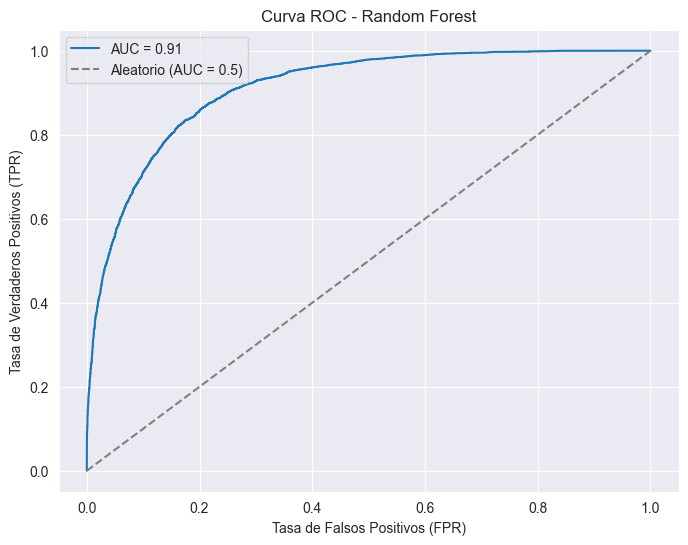

In [70]:
roc_auc = roc_auc_score(y_test, y_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.show()